# 1. Project Background

Today, burnout is often described as 'The Great Exhaustion' because according to a study published by Mercer in 2024, 8 out of 10 employees are at risk of burnout. It thus comes as no surprise that HR departments are very interested in monitoring their employees' burnout rate. Understanding and predicting employee burnout rates can provide organizations with the right insights to create supportive and healthy environments in the workplace.

This project aims to build a machine learning model to predict employee burnout rate from data such as gender, hours worked per day, designation, and the like.

# 2. Load Libraries & Data

In [20]:
# Impoting general libraries
import warnings
import itertools
import random

# Data Analysis Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mn

# Data Preparation, Modeling, and Evaluation (SKLearn Modules)
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler,RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Machine Learning Models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Machine Learning Model Evaluation Methods 
from sklearn.metrics import mean_squared_error

warnings.filterwarnings(action="ignore")
%matplotlib inline

In [21]:
#load train data set
train_df=pd.read_csv(r'D:\Machine_Learning_Foundations\datasets\train.csv')
train_df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


# 3. EDA

### 3.1 Missingness

In [22]:
train_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  str    
 1   Date of Joining       22750 non-null  str    
 2   Gender                22750 non-null  str    
 3   Company Type          22750 non-null  str    
 4   WFH Setup Available   22750 non-null  str    
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), str(5)
memory usage: 1.6 MB


From this , we see that only 3 features including the target variable has missing values.

<Axes: >

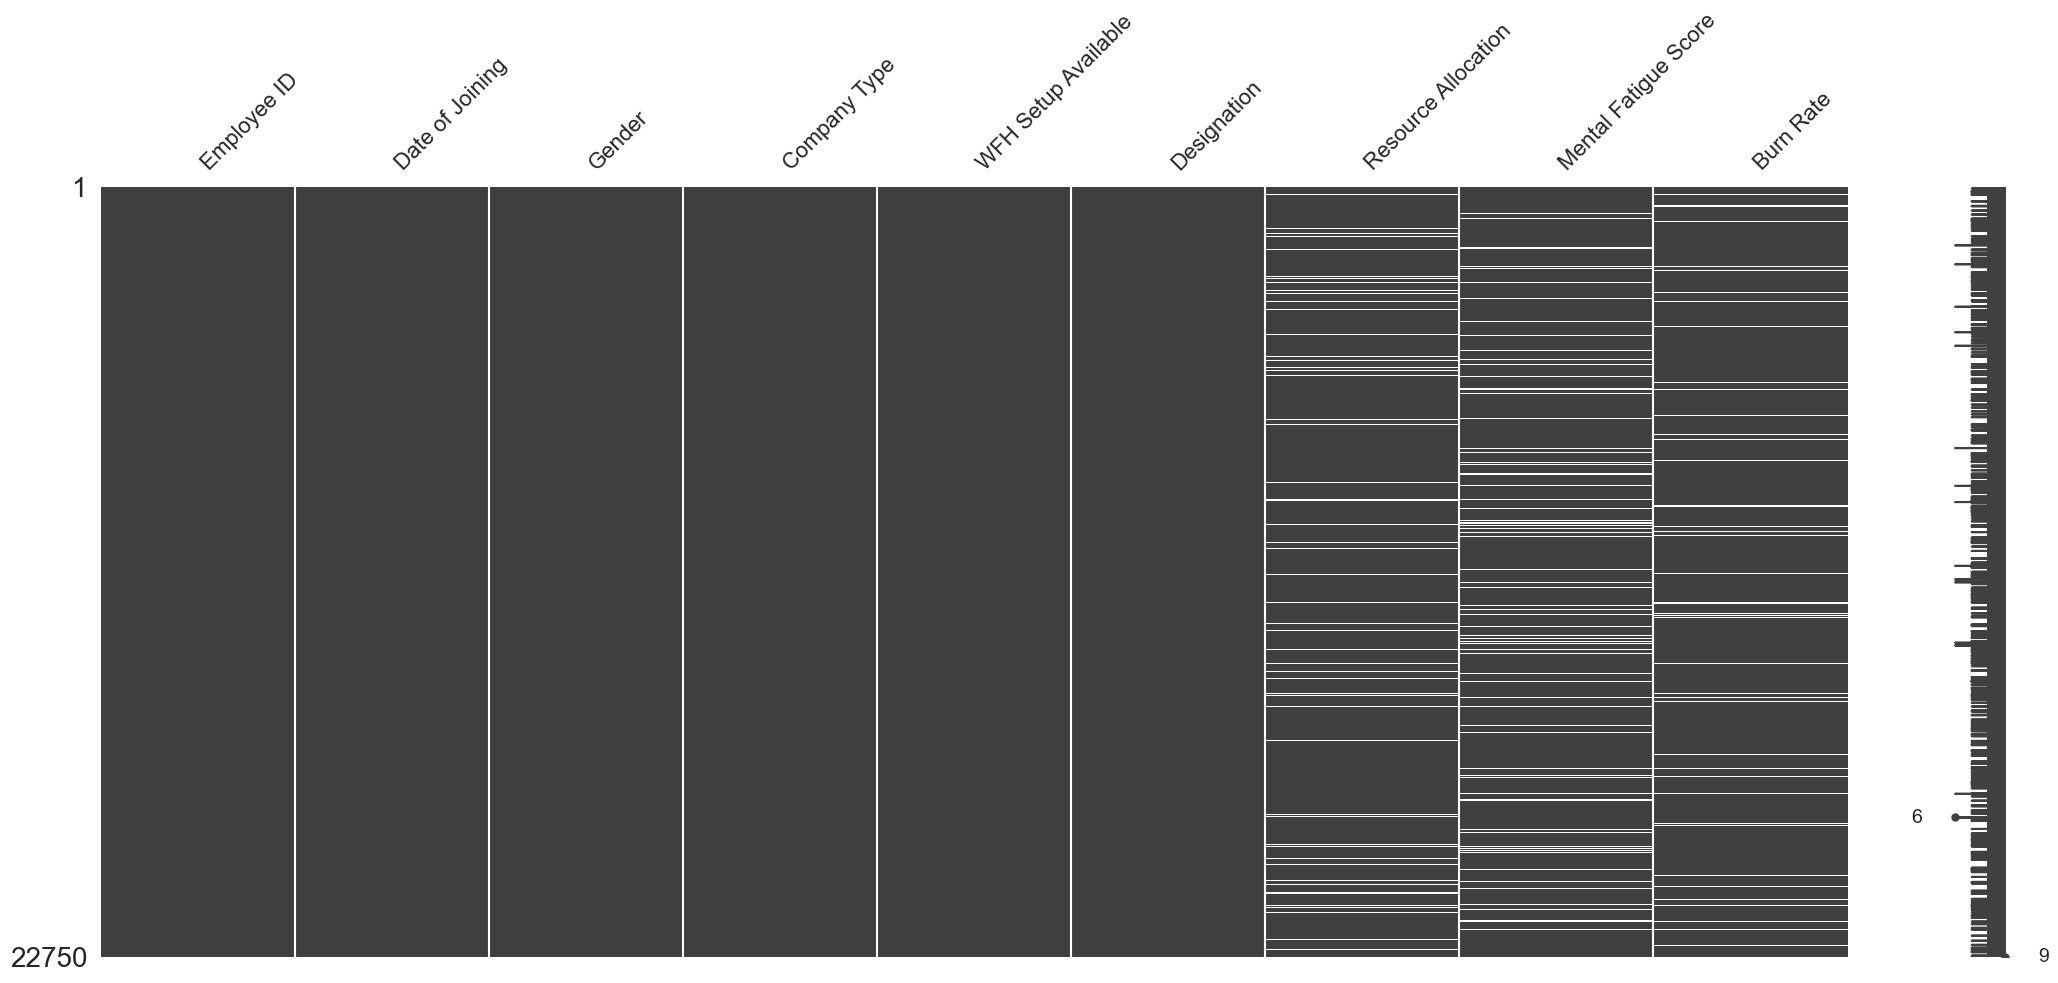

In [23]:
#plot matrix to visualize missingness
mn.matrix(train_df)

It is not advisable to impute rows with missing target variable, so drop all rows where the target variable is missing

<Axes: >

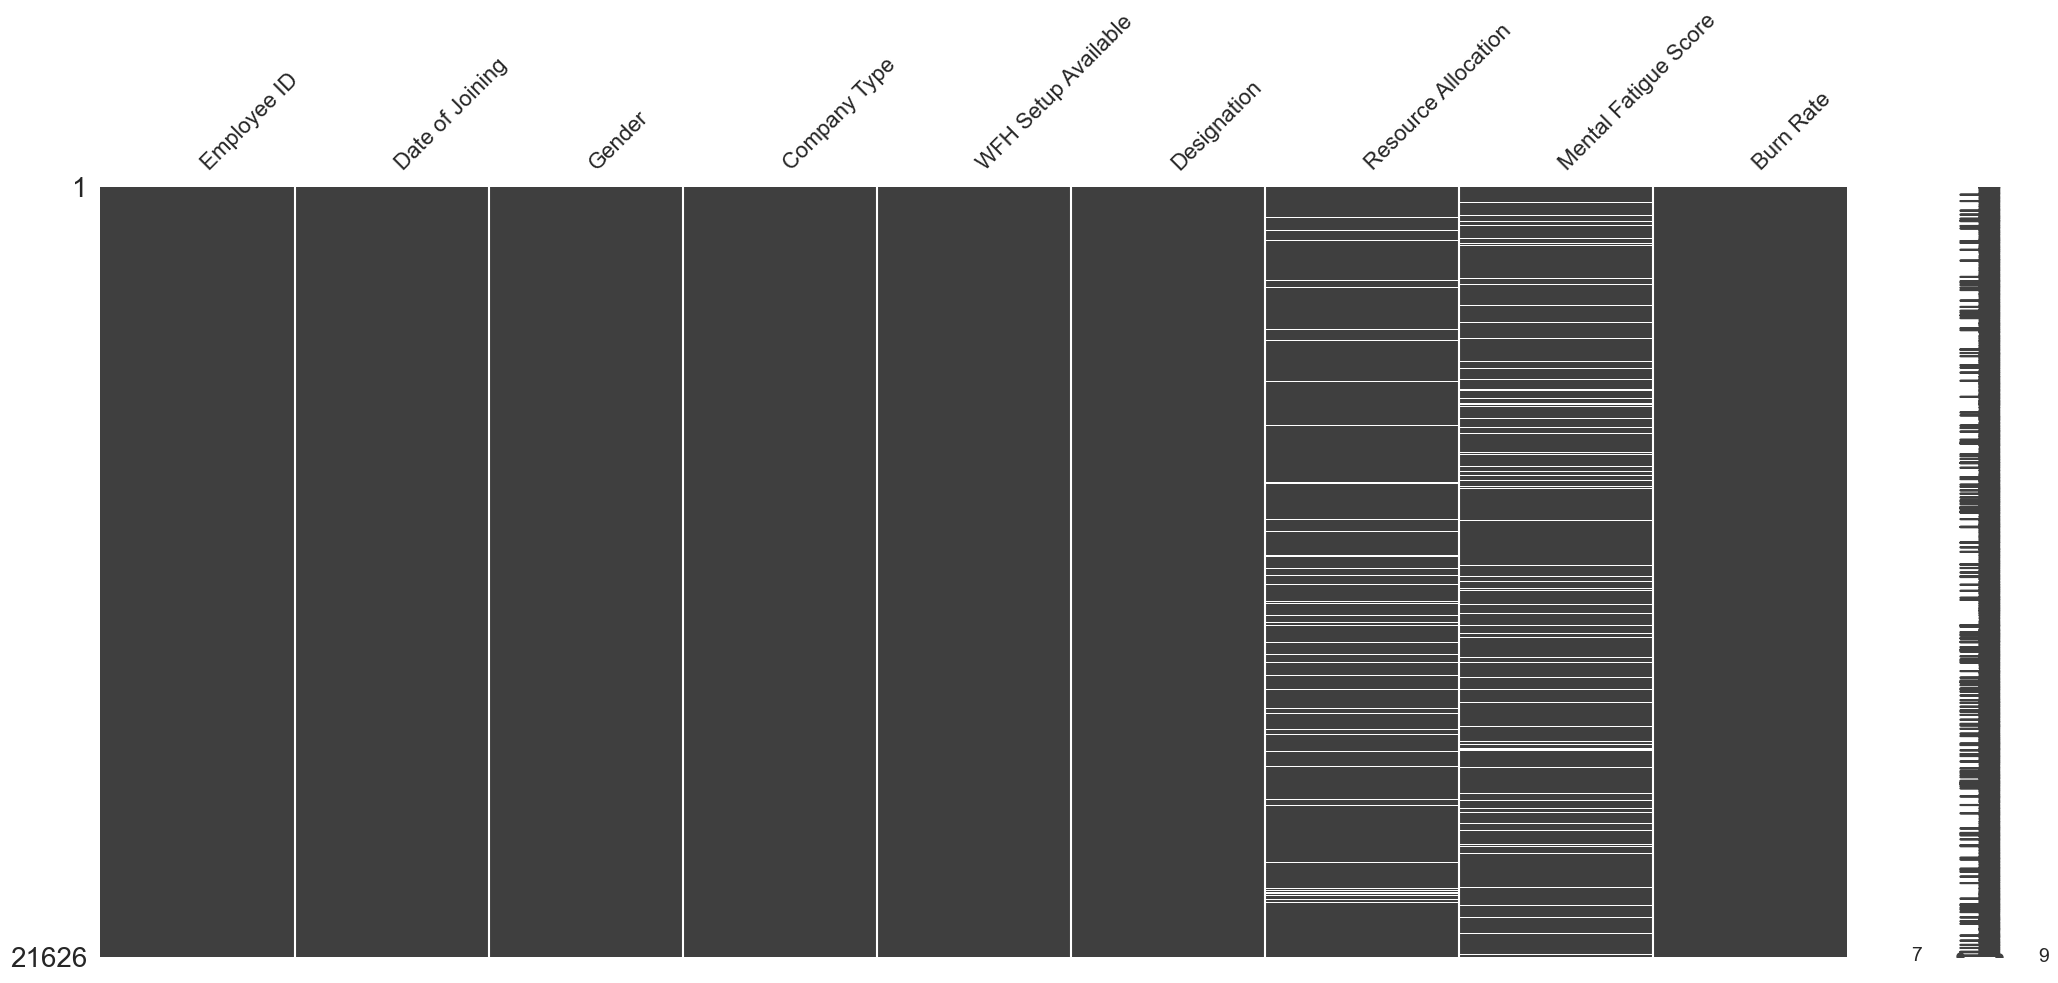

In [24]:
#drop null rows in the target column
train_df.dropna(subset=['Burn Rate'], inplace=True)
mn.matrix(train_df)

Now we need to calculate the proprotion of missingness in each column with missing values, in order to decide whether to drop or impute the data.

In [6]:
total_missing=train_df.isnull().sum().sort_values(ascending=False)
percent=train_df.isnull().sum().sort_values(ascending=False)/train_df.isnull().count().sort_values(ascending=False)
missing_df=pd.concat([total_missing,percent],axis=1,keys=['total_missing','percentage_missing'],sort=False)
missing_df.index.name='variable'# set the index name to variable 
missing_df=missing_df[total_missing>0] # only retain those with missing values 
missing_df['percentage_missing']=missing_df['percentage_missing'].map(lambda x:x*100) # convert to percentage 
missing_df

,total_missing,percentage_missing
variable,,
Mental Fatigue Score,1945,8.993804
Resource Allocation,1278,5.909553


Because each column has less very little missing values, we can proceed to impute values. To decide how to impute the values, we first explore the distribution of each variable with missing values.

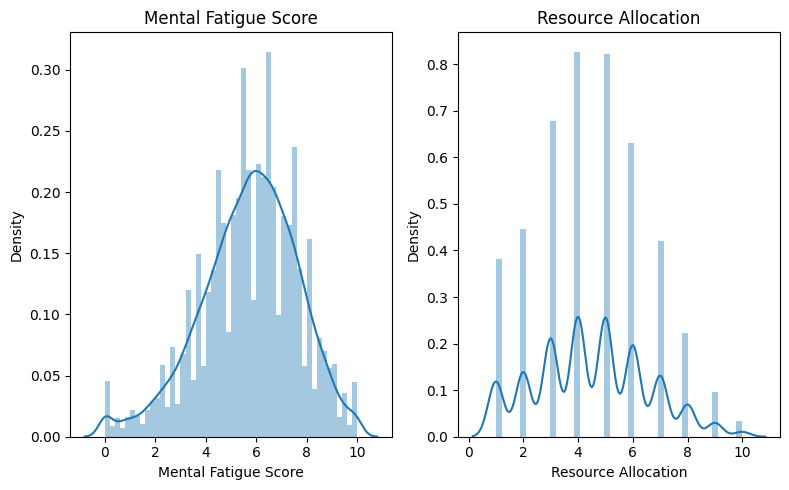

In [7]:
columns_to_plot=['Mental Fatigue Score','Resource Allocation']
fig = plt.figure(figsize=(8,5))
for i, column in enumerate(columns_to_plot):
    ax = fig.add_subplot(1, 2, i + 1)  
    sns.distplot(train_df[column],ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()

### Insights from distribution plots:
Mental Fatigue score has a normal distribution and therefore missing values can be imputed using mean.
Resource allocation has many peaks, therefore median imputation is best

In [8]:
#use fillna to impute
train_df['Mental Fatigue Score'].fillna(train_df['Mental Fatigue Score'].mean(),inplace=True)
train_df['Resource Allocation'].fillna(train_df['Resource Allocation'].median(),inplace=True)
train_df.info()

<class 'pandas.DataFrame'>
Index: 21626 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           21626 non-null  str    
 1   Date of Joining       21626 non-null  str    
 2   Gender                21626 non-null  str    
 3   Company Type          21626 non-null  str    
 4   WFH Setup Available   21626 non-null  str    
 5   Designation           21626 non-null  float64
 6   Resource Allocation   20348 non-null  float64
 7   Mental Fatigue Score  19681 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), str(5)
memory usage: 1.6 MB


### 3.2 Outliers

In [9]:
#separte the dataframe into numerical and categorical data
num_df=train_df.select_dtypes(include=[np.number])
cat_df=train_df.select_dtypes(include=[object])

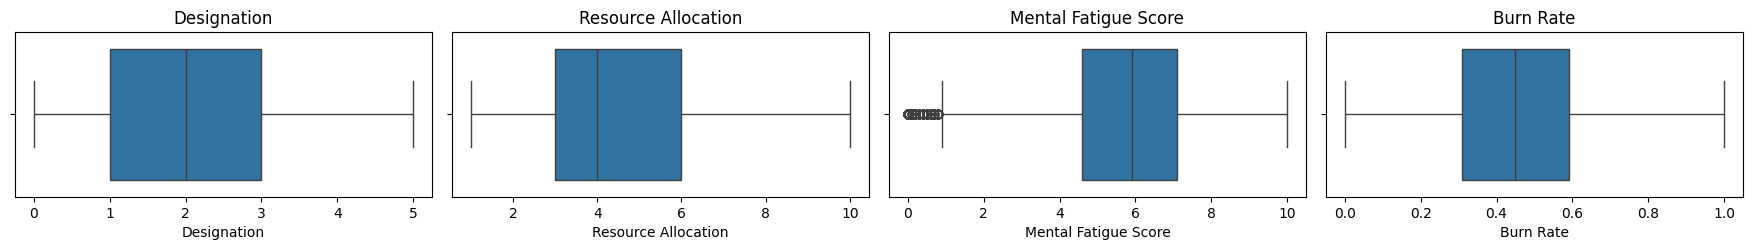

In [10]:
fig = plt.figure(figsize=(22,20))
for i in range(len(num_df.columns)):
    ax=fig.add_subplot(9, 5, i+1)
    sns.boxplot(x=num_df.iloc[:, i],ax=ax)
    ax.set_title(num_df.columns[i])
plt.tight_layout()
plt.show()

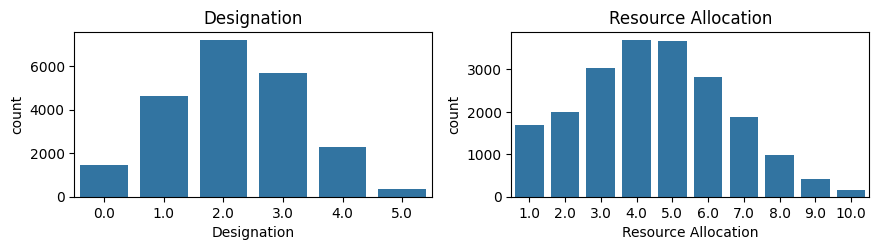

In [11]:
cols = ['Designation', 'Resource Allocation']
fig = plt.figure(figsize=(22,20))

for i, column in enumerate(num_df.columns):
    if column in cols:
        ax = fig.add_subplot(9, 5, i + 1)
        sns.countplot(x=num_df[column], ax=ax)
        ax.set_title(column)
        plt.tight_layout()

plt.show()

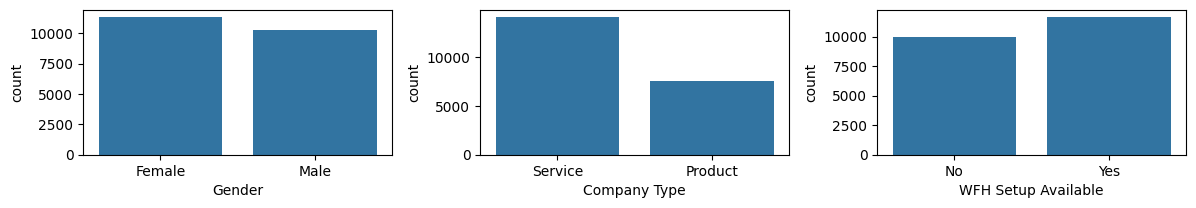

In [12]:
cat_df.drop(['Employee ID','Date of Joining'],axis=1,inplace=True)
fig = plt.figure(figsize=(20,18))
for i in range(len(cat_df.columns)):
    ax= fig.add_subplot(9, 5, i+1)
    sns.countplot(x=cat_df.iloc[:, i],ax=ax)
plt.tight_layout()
plt.show()

## ask how come the excluded columns are still being plotted****

You could also use employee id to handle duplicates.

### 3.3 Correlation

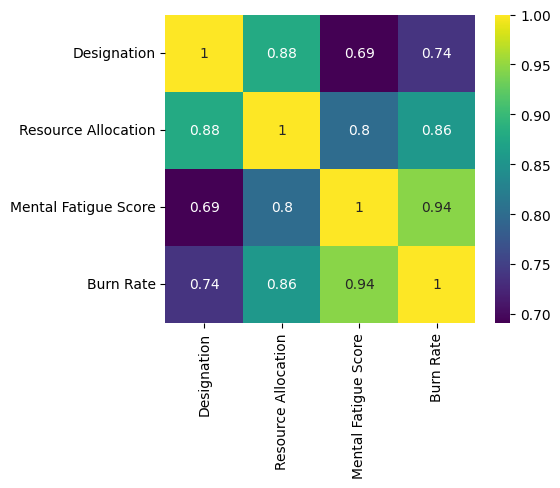

In [13]:
#correlation matrix
corrmat = num_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,4))
g=sns.heatmap(num_df[top_corr_features].corr(),annot=True,cmap="viridis")

Add multicollinearity analysis using VIF....

### 3.4 Bivariate Analysis

<Axes: title={'center': 'Company Type Vs Burn Rate'}, xlabel='Company Type', ylabel='Burn Rate'>

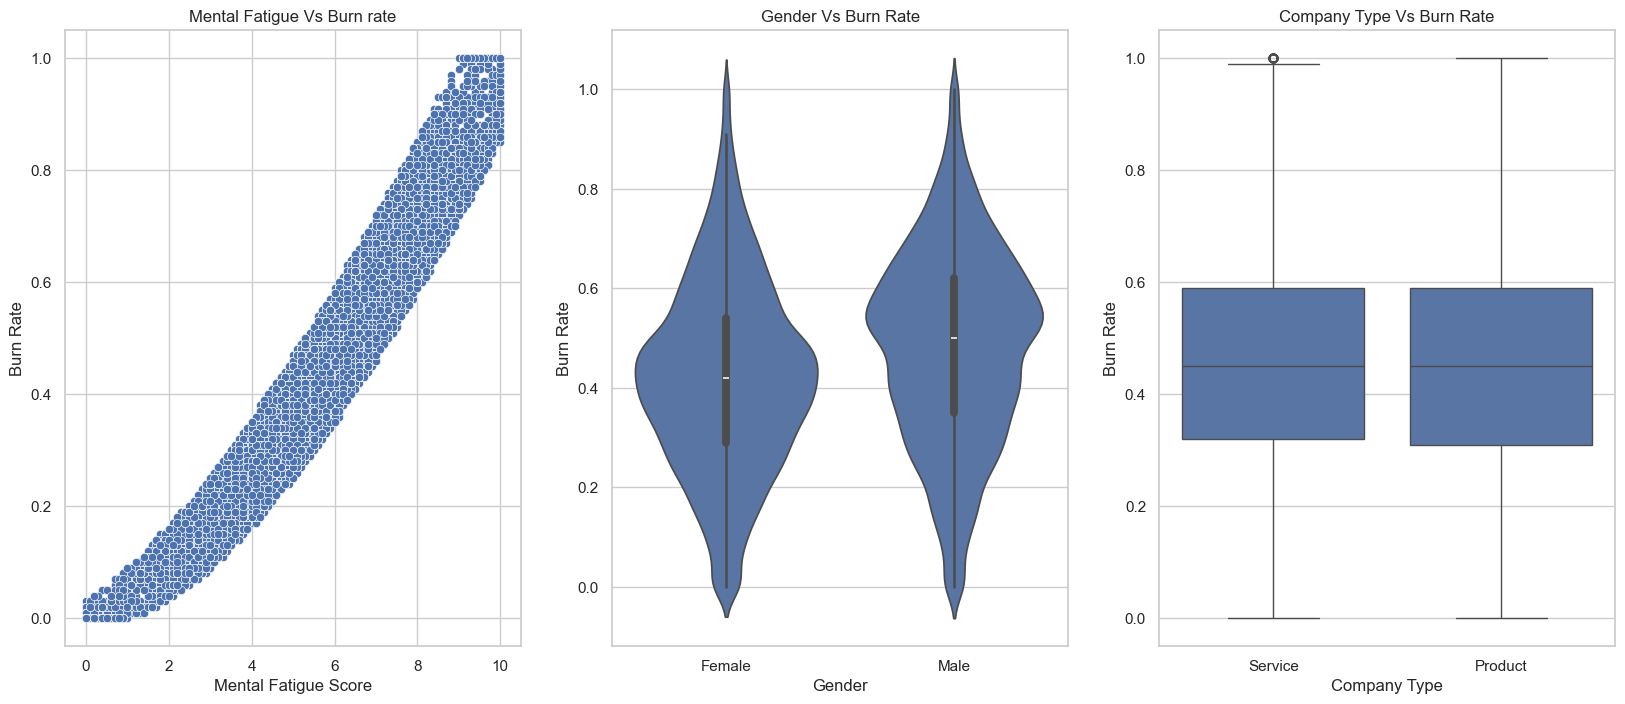

In [14]:
#Relationship between mental fatigue score and burn rate, gender and burn rate and company type and burnrate
sns.set(style="whitegrid")

fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
ax[0].set_title("Mental Fatigue Vs Burn rate")
sns.scatterplot(x='Mental Fatigue Score',y= 'Burn Rate', data= train_df,ax=ax[0])
ax[1].set_title("Gender Vs Burn Rate")
sns.violinplot(y='Burn Rate',x='Gender',data= train_df, ax=ax[1])
ax[2].set_title("Company Type Vs Burn Rate")
sns.boxplot(y='Burn Rate',data=train_df,x='Company Type',ax=ax[2])

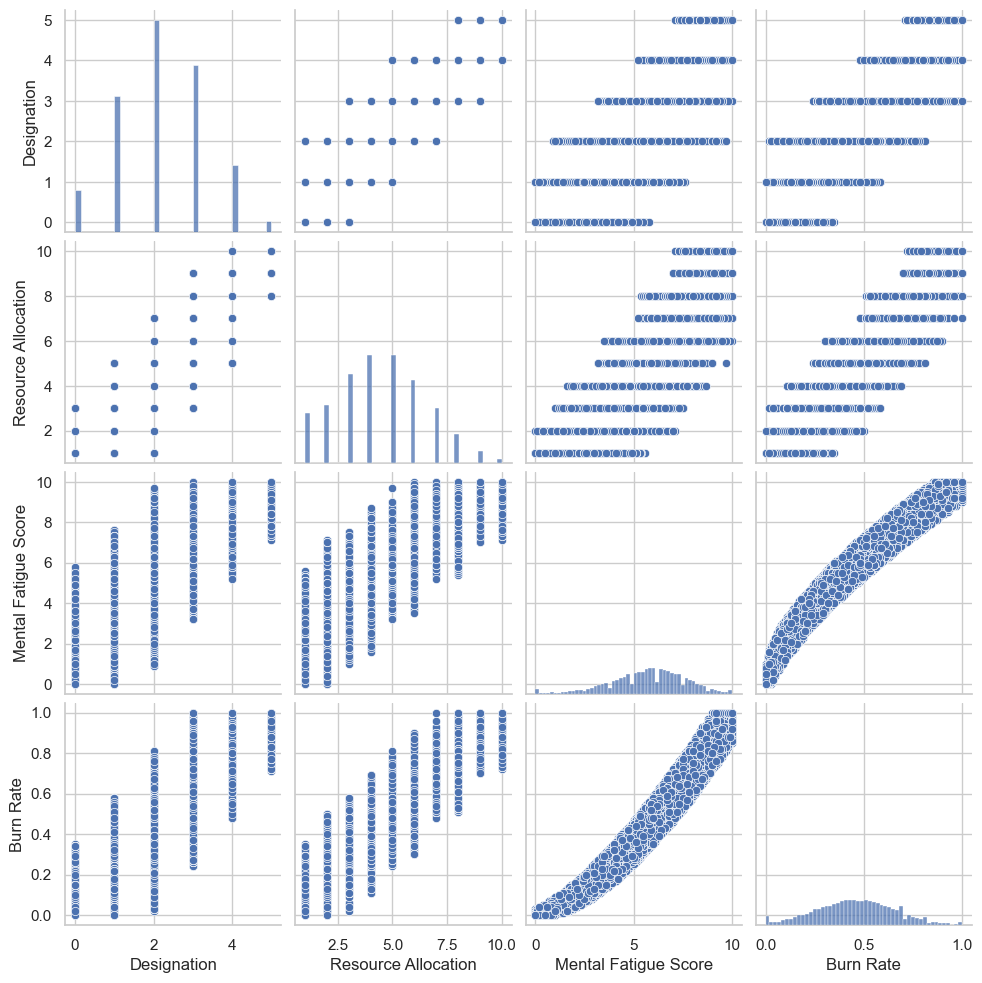

In [15]:
sns.pairplot(num_df)
plt.show()

Insights from Bivariate Analysis:
1. Burnout rate is directly proportional to Mental Fatigue score
2. Among both male and female employees,for majority, their burnout rate lies between o.4 and 0.6
3. There is very little difference in the burnout rate of employees in 'service' and 'product' departments.


# 4. Data Preprocessing

### 4.1 Feature Engineering

In my dataset we have the variable, 'Date of Joining', we can create another variable from this-'Tenure', which is how long each employee has been with the company to date.
NOTE: An assumption is made here: that the burnout rates were collected this year.

In [16]:
#first change the date column to datetime
from datetime import datetime
train_df['Date of Joining']=pd.to_datetime(train_df['Date of Joining'])
#get the date today
today=datetime.now()
# function that calculates months
def tenure_calc(join_date):
    total_months=(today.year-join_date.year)*12 + today.month-join_date.month
    return total_months

In [17]:
train_df['Tenure_in_months']=train_df['Date of Joining'].apply(tenure_calc)
#train_df.head(20)

In [18]:
train_df.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1278
Mental Fatigue Score    1945
Burn Rate                  0
Tenure_in_months           0
dtype: int64

### 4.2 Data Encoding

#### Feature Encoding Techniques

![image](assets\Type_of_categorical_data.png)

### Overview of Encoding Techniques

1. One Hot Encoding

best used on nominal categorical data. In one hot categorical encoding, for each level of a categorical feature, we create a new variable. Each category is mapped with a binary variable containing either 0 or 1. Here, 0 represents the absence, and 1 represents the presence of that category. Its limitation is that it increases the dimensionality of the data.

![input image](assets\One_hot_encoding.png)

2. Label Encoding
In Label Encoding, each unique category is assigned an integer between 0 and the number of classes. Downwise is that it can imply an ordering that does not exist, which misleads the machine learning model.

![input image](assets\Label_encoding.png)

3. Ordinal Encoding
Maps ordinal categories onto ordered integers.

![input image](assets\ordinal_encoding.png)

4. Dummy encoding
Dummy encoding is very similar to one-hot encoding but with one key difference, it drops one of the columns. When Kisumu, Nakuru and Mombasa are 0, the model knows it must be Nairobi. That dropped category is called the reference category or dummy trap baseline.

![input image](assets\dummy_encoding.png)

***Further reading***
Other types of encoding, binary encoding, base N encoding, target encoding etc...

Which encoder should we use for our dataset here?

In [19]:
ohe=OneHotEncoder(sparse_output=False)
ohe_transform=ohe.fit_transform(cat_df)
encoded_df = pd.DataFrame(ohe_transform, columns=ohe.get_feature_names_out(cat_df.columns))
#encoded_df.isnull().sum()
encoded_df.index = cat_df.index
final_df=pd.concat([train_df,encoded_df],axis=1)
final_df.drop(['Employee ID','Gender','Date of Joining','Company Type','WFH Setup Available'],axis=1,inplace=True)
final_df.isnull().sum()

Designation                   0
Resource Allocation        1278
Mental Fatigue Score       1945
Burn Rate                     0
Tenure_in_months              0
Gender_Female                 0
Gender_Male                   0
Company Type_Product          0
Company Type_Service          0
WFH Setup Available_No        0
WFH Setup Available_Yes       0
dtype: int64

# 5. Modelling with preprocessed data

Predicting the burnout rate based on employee metrics is a regression problem.For the project we will apply a simple linear regression model, support vector machine and random forest.

In [18]:
#split the data
X=final_df.drop('Burn Rate',axis=1)
y=final_df[['Burn Rate']]


In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17300, 10) (4326, 10) (17300, 1) (4326, 1)


### Feature Scaling

Feature scaling is the process of bringing all numerical features onto a similar scale so that no single feature dominates the model just because it has larger numbers.
For example, if you have Age (ranging 0–100) and Salary (ranging 10,000–100,000), a model would almost entirely base its decisions on Salary just because the numbers are bigger, even if Age is equally important.


1. Min-Max Scaling (Normalization)

Squishes all values into a fixed range, usually 0 to 1. Good when you know the data has a fixed range and no extreme outliers

 ```(x - min) / (max - min)```


 2. Standardization (Z-score Scaling)
Centers the data around 0 with a standard deviation of 1. This is the most commonly used technique. Unlike min-max, it doesn't bound values to a specific range, so it handles outliers better. Works well for linear models, logistic regression, SVM.

```(x - mean) / standard deviation```

3. Robust Scaling
Similar to standardization but uses the median and IQR (interquartile range) instead of mean and standard deviation.Best choice when your data has a lot of outliers, since median and IQR are not affected by extreme values the way mean and standard deviation are.

```(x - median) / IQR```

4. Max Abs Scaling
Scales each feature by its maximum absolute value, so values end up between -1 and 1. Useful when your data is already centered at zero or is sparse (lots of zeros), like in text data.

#### How to choose the right method
the appropriate scaling technique is dependent on the model you plan to use and whether there are extreme outliers or not. If you plan to use tree based models, no need for feature scaling. If there are extreme outliers in your data, use Robust scaling if not z-score or min-max is okay.



In [20]:
#apply normalization 
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [21]:
#regression with OLS
#initiate the model,specificy the evaluation metric, apply cross validation of 5 folds
reg=LinearRegression()
mse_score=make_scorer(mean_squared_error)
scores=cross_val_score(reg, X_train, y_train,cv=5,scoring=mse_score)
print(scores,scores.mean())

[0.00493875 0.0048062  0.00549761 0.00478662 0.00512367] 0.005030570643944904


In [22]:
#regression with lasso regression
las_model=Lasso()
mse_score=make_scorer(mean_squared_error)
scores=cross_val_score(las_model, X_train, y_train,cv=5,scoring=mse_score)
print(scores,scores.mean())

[0.03878431 0.04017774 0.03918127 0.03978718 0.03896089] 0.03937827577287079


In [23]:
#Support Vector Regression
svr_model=SVR()
mse_score=make_scorer(mean_squared_error)
scores=cross_val_score(svr_model, X_train, y_train,cv=5,scoring=mse_score)
print(scores,scores.mean())

[0.00437325 0.00436125 0.00462387 0.00430454 0.00456134] 0.004444850179781691


In [24]:
rfr=RandomForestRegressor()
mse_score=make_scorer(mean_squared_error)
scores=cross_val_score(rfr, X_train, y_train,cv=5,scoring=mse_score)
print(scores,scores.mean())

[0.00434032 0.00426941 0.00454587 0.00419808 0.00436117] 0.0043429700302916865


The best performing models are those with mse scores of close to 0 which is the Support Vector Regressor and the Random Forest Regressor. Now we can do hyper parameter tuning, focusing on the 2 models.

# 6. HyperParameter Tuning

#### Using GridSearch CV

In [29]:
# Define the model
model = RandomForestRegressor(random_state=42)

# Define the hyperparameters to tune
search_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
#make a gridsearch cv object
GSV = GridSearchCV(estimator=model, param_grid=search_space, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
GSV.fit(X_train,y_train)

best_params_random = GSV.best_params_
best_score_random = -GSV.best_score_
print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Score (Random Search, MSE): {best_score_random}")

Best Parameters (Random Search): {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score (Random Search, MSE): 0.003645672549764995


In [31]:
# Define the model
model = SVR()

# Define the hyperparameters to tune
search_space = {
   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 1.0]
}
#make a gridsearch cv object
GSV = GridSearchCV(estimator=model, param_grid=search_space, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
GSV.fit(X_train,y_train)

best_params_random2 = GSV.best_params_
best_score_random2 = -GSV.best_score_
print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Score (Random Search, MSE): {best_score_random}")

Best Parameters (Random Search): {'C': 1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score (Random Search, MSE): 0.004469636611056469


# 6 Model Evaluation

In [32]:
#Evaluating the RandomForestRegressor with the optimized parameters
best_params1={
    'bootstrap': True,
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 200
}
best_rfr=RandomForestRegressor(**best_params1)
best_rfr.fit(X_train,y_train)
y_predict=best_rfr.predict(X_test)
mse=mean_squared_error(y_test,y_predict)
print('Model error: ', mse)


Model error:  0.003986858615047257


In [33]:
#Evaluating the Support Vector Regressor with the optimized parameters
best_params1={
    'C': 1,
    'epsilon': 0.1,
    'gamma': 'auto',
    'kernel': 'rbf'
}
best_svr=SVR(**best_params1)
best_svr.fit(X_train,y_train)
y_predict=best_svr.predict(X_test)
mse=mean_squared_error(y_test,y_predict)
print('Model error: ', mse)


Model error:  0.004760164630090583


### Insights from Model Hyperparameter Tuning & Evaluation
1. Hyperparameter tuning only slightly increased the performance of the RandomForestRegressor model from 0.0043 to 0.0039. It however slightly decreased the performance of the Support Vector Regression model from 0.0044 to 0.00476
2. Both models show very high levels of accuracy because the mean squared error is practically zero- indicative of a very good model.

In [ ]:
#do these slight differences even matter?